# 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

El alumno, con los datos preprocesados del ejercicio 2, **deberá entrenar dos
modelos distintos** de los que, tras comparar sus resultados, elegirá uno como el mejor.
Para tomar esta decisión se basará en las métricas que calcule (precision, recall, f1-score,
...). **El enfoque será el de un problema de clasificación binaria supervisada.**

Los modelos deberán tomar a su entrada los datos codificados con un modelo de
bolsa de palabras (**bag-of-words**). Se deberán justificar los parámetros del vectorizer, así
como tener en cuenta aspectos como el balanceo de clases.

**La elección de los modelos es libre.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import random
import pickle

## Obtenemos los datasets

In [3]:
# Comprobamos a abrirlos de nuevo
train_data = pd.read_csv("/content/drive/MyDrive/train_data_preprocesado.csv", sep=';')
test_data = pd.read_csv("/content/drive/MyDrive/test_data_preprocesado.csv", sep=';')
train_data.shape, test_data.shape

((800, 2), (200, 2))

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  800 non-null    int64 
 1   text    798 non-null    object
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [5]:
# como tenemos NAN los eliminamos
train_data = train_data.dropna()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  798 non-null    int64 
 1   text    798 non-null    object
dtypes: int64(1), object(1)
memory usage: 18.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  200 non-null    int64 
 1   text    200 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


## Preparamos la data para usar BoW

In [7]:
# Separamos las reviews en datasets de data
data_train = [text for text in train_data['text']]
data_test = [text for text in test_data['text']]
len(data_train), len(data_test)

(798, 200)

In [8]:
# Creamos dos datasets con palabras
words_train = [str(text).split() for text in data_train]
words_test = [str(text).split() for text in data_test]
len(words_train), len(words_test)

(798, 200)

In [9]:
# Separamos las reviews en datasets de labels
labels_train = [rating for rating in train_data['rating']]
labels_test = [rating for rating in test_data['rating']]
len(labels_train), len(labels_test)

(798, 200)

In [10]:
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


--- Raw review ---
great set cd like old style countri music

--- Preprocessed words ---
['great', 'set', 'cd', 'like', 'old', 'style', 'countri', 'music']

--- Label ---
1


In [11]:
# Obtenos el tamaño maximo de palabras en un documento
vocabulary_train_size = max(len(x) for x in words_train )
vocabulary_test_size = max(len(x) for x in words_test )
vocabulary_train_size, vocabulary_test_size

(839, 918)

## BoW

In [12]:
def extract_BoW_features(words_train, words_test, vocabulary_size=5000):
  """Extract Bag-of-Words for a given set of documents"""

  vectorizer = CountVectorizer(max_features=vocabulary_size,
          preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
  features_train = vectorizer.fit_transform(words_train).toarray()

  features_test = vectorizer.transform(words_test).toarray()

  vocabulary = vectorizer.vocabulary_

  return features_train, features_test, vocabulary


In [13]:
# Extraemos las features usando BoW
# usamos como tamaño de vocabulario la cantidad máxima de palabras encontradas en un documento
# Lo que encontramos es que en test hay mas palabras, por eso vamos a usar ese valor como límite
features_train, features_test, vocabulary = extract_BoW_features(words_train,
                                                                 words_test,
                                                                 vocabulary_test_size)

print("Vocabulary: {} words".format(len(vocabulary)))

print("\nSample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Vocabulary: 918 words

Sample words: ['pretti', 'angri', 'truli', 'eighteen', 'men', 'line', 'japan', 'william']

--- Preprocessed words ---
['long', 'time', 'consum', 'sea', 'song', 'chang', 'found', 'cd', 'adequ', 'best', 'represent', 'may', 'record', 'mystic', 'festiv', 'excel', 'venu', 'high', 'point', 'wade', 'water', 'much', 'present', 'rather', 'inspir', 'nonetheless', 'belong', 'librari', 'anyon', 'enjoy', 'sea', 'music']

--- Bag-of-Words features ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Guardamos los datos procesados por Bow

In [14]:
def save_pkl(model_name, model):
  # create an iterator object with write permission - model.pickle
  with open(model_name, 'wb') as files:
    pickle.dump(model, files)

In [15]:
def load_pkl(model_name):
  # load saved model
  with open(model_name , 'rb') as f:
      lr = pickle.load(f)
  return lr

In [16]:
preprocessed_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
preprocessed_data.keys()

dict_keys(['words_train', 'words_test', 'labels_train', 'labels_test'])

In [17]:
save_pkl('preprocessed_data.pkl', preprocessed_data)

In [18]:
!cp preprocessed_data.pkl /content/drive/MyDrive/preprocessed_data.pkl

In [19]:
# obtenes la data guardada
preprocessed_data = load_pkl('/content/drive/MyDrive/preprocessed_data.pkl')
preprocessed_data.keys()

dict_keys(['words_train', 'words_test', 'labels_train', 'labels_test'])

In [20]:
# Ahora guardamos las features de BoW
bow_features = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
bow_features.keys()

dict_keys(['features_train', 'features_test', 'vocabulary'])

In [21]:
save_pkl('bow_features.pkl', bow_features)

In [22]:
!cp bow_features.pkl /content/drive/MyDrive/bow_features.pkl

In [23]:
# obtenes la data guardada
bow_features = load_pkl('/content/drive/MyDrive/bow_features.pkl')
bow_features.keys()

dict_keys(['features_train', 'features_test', 'vocabulary'])

## Normalización de features

In [24]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

## Entrenamiento de varios modelos

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
# creamos variables standard
x_features_train = features_train
y_labels_train = labels_train

x_features_test = features_test
y_labels_test = labels_test

In [27]:
# Configuramos una semilla que va a ser utilizada para entrenar todos los modelos
global_seed = 42

# Creamos un array de modelos an entrenar
# Como va a ser una revisión general de modelos, no se pone mucho enfasis
# en configurar los diferentes parámetres
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=global_seed)))
models.append(("LASSO", lm.LogisticRegression(random_state=global_seed)))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=global_seed)))
models.append(("SVM", SVC(random_state=global_seed)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=global_seed)
))

# Creamos arrays para almacenar los resultados
results = []
names = []

# setemos en 0 los mejores resultados
best_mean_result = 0
best_std_result = 0

# Corremos todos los modelos utilizando StratifiedKFlod y cross_val_score
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, x_features_train, y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nEl mejor modelo es:\n" + best_model_name)

Random Forest: mean(accuracy)=0.798, std(accuracy)=0.012
LASSO: mean(accuracy)=0.783, std(accuracy)=0.006
KNN: mean(accuracy)=0.769, std(accuracy)=0.007
Decision Tree: mean(accuracy)=0.723, std(accuracy)=0.03
SVM: mean(accuracy)=0.782, std(accuracy)=0.012
Gradient Boosting: mean(accuracy)=0.771, std(accuracy)=0.013

El mejor modelo es:
Random Forest


## Boxplot del accuracy de los modelos

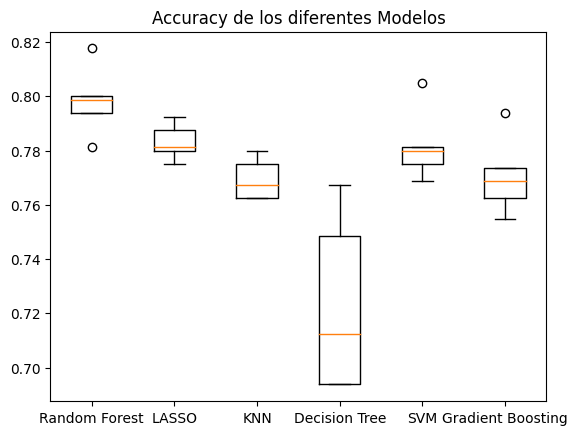

In [28]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Accuracy de los diferentes Modelos")
matplotlib.pyplot.show()

## Entrenamos y testamos el modelo Random Forest, ya que fue el que mejor resultado pre-eliminar arrojo

In [29]:
# modelo a entrenar
model = RandomForestClassifier()

# Elegimos algunos hiperparámetros para buscar el óptimo
params = {"n_estimators": range(10, 31, 3),
           "min_samples_split": range(2, 10, 2)}

# Entrenamos usando grid_search para encontrar los hiperparámetros óptimos
grid_search = GridSearchCV(model, params)
grid_search.fit(x_features_train, y_labels_train)

print("El 'n_estimators' optimo es:", grid_search.best_params_["n_estimators"])
print("El 'min_samples_split' optimo es:", grid_search.best_params_["min_samples_split"])

El 'n_estimators' optimo es: 28
El 'min_samples_split' optimo es: 8


In [30]:
# Configuramos el modelo con los hiperparámetros óptimos
model = RandomForestClassifier(n_estimators=grid_search.best_params_["n_estimators"],
                                min_samples_split=grid_search.best_params_["min_samples_split"],
                                )

# Entrenamos el modelo
model.fit(x_features_train, y_labels_train)

RandomForestClassifier(min_samples_split=8, n_estimators=28)

## Generamos los resultados de TRAIN

In [31]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
if(baseline_accuracy_train != 0):
  accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)
else:
  accuracy_lift_train = 0

print("Resultados en TRAIN utilizando Random Forest:\n-------------------------")
print("Baseline accuracy:", round(baseline_accuracy_train, 2))
print("accuracy:", round(accuracy_train, 2))
print("accuracy lift:", round(accuracy_lift_train), "%")

Resultados en TRAIN utilizando Random Forest:
-------------------------
Baseline accuracy: 0.0
accuracy: 0.98
accuracy lift: 0 %


## Generamos los resultados de TEST

In [32]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
if(baseline_accuracy_train != 0):
  accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)
else:
  accuracy_lift = 0

print("Resultados en TEST utilizando Random Forest:\n-------------------------")
print("Baseline accuracy:", round(baseline_accuracy_test, 2))
print("accuracy:", round(accuracy_test, 2))
print("accuracy lift:", round(accuracy_lift), "%")

Resultados en TEST utilizando Random Forest:
-------------------------
Baseline accuracy: 0.0
accuracy: 0.79
accuracy lift: 0 %


## Guardamos el modelo y los datos de entrenamiento

In [33]:
save_pkl('model_random_forest.pkl', model)

In [34]:
!cp model_random_forest.pkl /content/drive/MyDrive/model_random_forest.pkl

In [35]:
# obtenes la data guardada
model = load_pkl('/content/drive/MyDrive/model_random_forest.pkl')
model

RandomForestClassifier(min_samples_split=8, n_estimators=28)

In [36]:
model_features = dict(x_features_train=x_features_train,
                      y_labels_train=y_labels_train,
                      x_features_test=x_features_test,
                      y_labels_test=y_labels_test)
model_features.keys()

dict_keys(['x_features_train', 'y_labels_train', 'x_features_test', 'y_labels_test'])

In [37]:
save_pkl('model_features.pkl', model_features)

In [38]:
!cp model_features.pkl /content/drive/MyDrive/model_features.pkl

In [39]:
# obtenes la data guardada
model_features = load_pkl('/content/drive/MyDrive/model_features.pkl')
model_features.keys()

dict_keys(['x_features_train', 'y_labels_train', 'x_features_test', 'y_labels_test'])

## Conclusión

Solo probamos con modelos Machine Learning por cuestiones de tiempo.

Realizamos el BoW y corrimos diferentes modelos de entrenamiento con parámetros genéricos.

En este primer análisis, el modelo que mejor accuracy obtuvo fue Random Forest.

Debido a esto procedimos a intentar encontrar algunos hiperparámetros óptimos y pasar a entrenar el modelo con los mismos.

Además tratamos de guardar todos los datos que nos puedan servir para realizar el reporte de métricas.